<a href="https://colab.research.google.com/github/cnn22/SingerSongwriter/blob/main/RNN_Emotions_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [2]:
%cd .
! git clone https://github.com/surmenok/keras_lr_finder
%cd keras_lr_finder
! python3 -m pip install --editable .
%cd /content

/content
Cloning into 'keras_lr_finder'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 68 (delta 1), reused 0 (delta 0), pack-reused 62
Unpacking objects: 100% (68/68), done.
/content/keras_lr_finder
Obtaining file:///content/keras_lr_finder
  Running setup.py develop for keras-lr-finder
/content/keras_lr_finder


In [16]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras_lr_finder import LRFinder

# Reading and Cleaning data

In [20]:
#Read in data
train_df = pd.read_csv('train.txt', ';', header=None, names=['Sentence', 'Emotion'], index_col=False)
test_df = pd.read_csv('test.txt', ';', header=None, names=['Sentence', 'Emotion'], index_col=False)

In [21]:
test_df.Emotion.unique()

array(['sadness', 'joy', 'fear', 'anger', 'love', 'surprise'],
      dtype=object)

## Turn into number target labels

In [22]:
train_df.loc[train_df.Emotion == 'sadness', 'Emotion'] = 0
train_df.loc[train_df.Emotion == 'anger', 'Emotion'] = 1
train_df.loc[train_df.Emotion == 'love', 'Emotion'] = 2
train_df.loc[train_df.Emotion == 'surprise', 'Emotion'] = 3
train_df.loc[train_df.Emotion == 'fear', 'Emotion'] = 4
train_df.loc[train_df.Emotion == 'joy', 'Emotion'] = 5

In [23]:
test_df.loc[test_df.Emotion == 'sadness', 'Emotion'] = 0
test_df.loc[test_df.Emotion == 'anger', 'Emotion'] = 1
test_df.loc[test_df.Emotion == 'love', 'Emotion'] = 2
test_df.loc[test_df.Emotion == 'surprise', 'Emotion'] = 3
test_df.loc[test_df.Emotion == 'fear', 'Emotion'] = 4
test_df.loc[test_df.Emotion == 'joy', 'Emotion'] = 5

## Process Data for TensorFlow

In [24]:
train_df.Emotion = train_df.Emotion.astype('int64')
test_df.Emotion = test_df.Emotion.astype('int64')

In [25]:
#converting pandas df into a 'TensorSliceDataset' type so we can use tensor flow objects...

train = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(train_df['Sentence'].values, tf.string),
            tf.cast(train_df['Emotion'].values, tf.int64)
        )
    )
)

test = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(test_df['Sentence'].values, tf.string),
            tf.cast(test_df['Emotion'].values, tf.int64)
        )
    )
)

## Split Data into Test and Train

In [26]:
#Shuffle the train and test data sets
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train = train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test = test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [27]:
for example, label in train.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'i feel frustrated sometimes with my mac lipsticks when i have to read names or open each of them to select shade'
 b'i literally just text tychelle to see if she wants to hang out because reading what i just wrote about my nonexistent social life made me feel so pathetic'
 b'i love feeling brave']

labels:  [1 0 5]


# Encode Text


In [28]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)

encoder.adapt(train.map(lambda text, label: text))

In [29]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'i', 'feel', 'and', 'to', 'the', 'a', 'that',
       'feeling', 'of', 'my', 'in', 'it', 'like', 'so', 'for', 'im', 'me',
       'but'], dtype='<U13')

# Creating the Model

## First iteration

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6) #this is the output layer, since we have 6 emotions we should have 6 as the output number instead of 1
])

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

### Train the Model

In [ ]:
history = model.fit(train, epochs=10,
                    validation_data=test,
                    validation_steps=30)

Epoch 1/10
250/250 [==============================] - 34s 108ms/step - loss: 1.6728 - accuracy: 0.3290 - val_loss: 1.5680 - val_accuracy: 0.3604
Epoch 2/10
250/250 [==============================] - 25s 100ms/step - loss: 1.5620 - accuracy: 0.3613 - val_loss: 1.5291 - val_accuracy: 0.3802
Epoch 3/10
250/250 [==============================] - 25s 100ms/step - loss: 1.4791 - accuracy: 0.4098 - val_loss: 1.3450 - val_accuracy: 0.4901
Epoch 4/10
250/250 [==============================] - 25s 100ms/step - loss: 1.1382 - accuracy: 0.5885 - val_loss: 0.9681 - val_accuracy: 0.6672
Epoch 5/10
250/250 [==============================] - 25s 100ms/step - loss: 0.8903 - accuracy: 0.6736 - val_loss: 0.8401 - val_accuracy: 0.6953
Epoch 6/10
250/250 [==============================] - 25s 101ms/step - loss: 0.7868 - accuracy: 0.6931 - val_loss: 0.7745 - val_accuracy: 0.7047
Epoch 7/10
250/250 [==============================] - 25s 100ms/step - loss: 0.7318 - accuracy: 0.7110 - val_loss: 0.7303 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

32/32 [==============================] - 1s 25ms/step - loss: 0.6414 - accuracy: 0.7915
Test Loss: 0.641374945640564
Test Accuracy: 0.7914999723434448


(0.0, 1.7257527738809586)

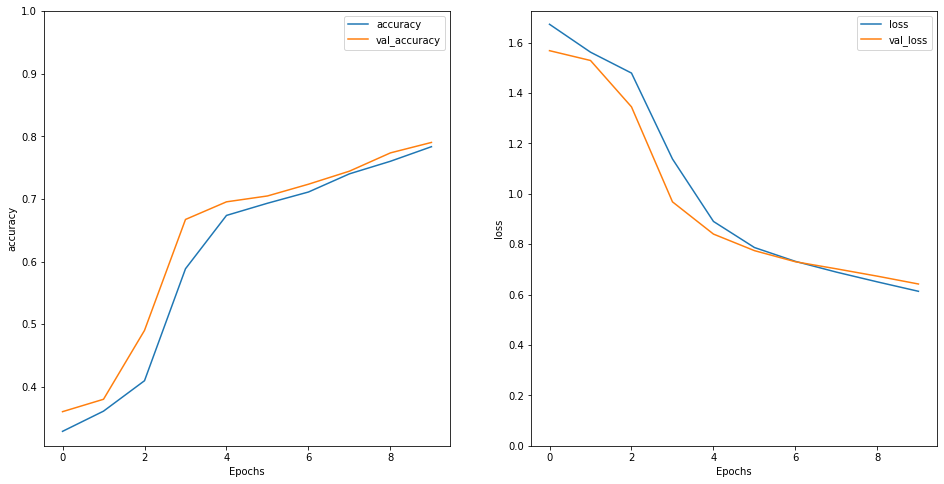

In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])


plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)


## Further experimentation

### Find Best Learning Rate

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(6) #this is the output layer, since we have 6 emotions we should have 6 as the output number instead of 1
    ])

model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

lr_finder = LRFinder(model)
lr_finder.find(train_df["Sentence"],train_df["Emotion"], start_lr=1e-6, end_lr=1, epochs=10,
               steps_per_epoch=np.ceil(len(train_df) / BATCH_SIZE))

Epoch 1/10
250/250 [==============================] - 25s 102ms/step - loss: 1.7906 - accuracy: 0.1998
Epoch 2/10
250/250 [==============================] - 26s 103ms/step - loss: 1.7833 - accuracy: 0.3196
Epoch 3/10
250/250 [==============================] - 26s 102ms/step - loss: 1.6914 - accuracy: 0.3348
Epoch 4/10
250/250 [==============================] - 25s 102ms/step - loss: 1.5550 - accuracy: 0.3441
Epoch 5/10
250/250 [==============================] - 26s 103ms/step - loss: 1.0504 - accuracy: 0.5817
Epoch 6/10
250/250 [==============================] - 26s 103ms/step - loss: 0.5630 - accuracy: 0.8042
Epoch 7/10
250/250 [==============================] - 26s 103ms/step - loss: 0.4191 - accuracy: 0.8558
Epoch 8/10
250/250 [==============================] - 26s 102ms/step - loss: 0.5637 - accuracy: 0.8107
Epoch 9/10
250/250 [==============================] - 1s 3ms/step - loss: 1.3668 - accuracy: 0.4844


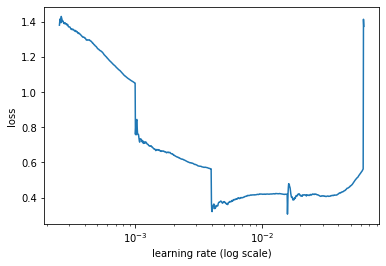

In [ ]:
lr_finder.plot_loss(n_skip_beginning=1000, n_skip_end=5)

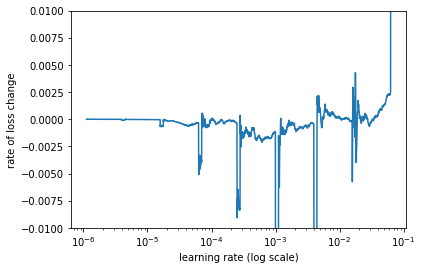

In [ ]:
lr_finder.plot_loss_change(sma=20, n_skip_beginning=20, n_skip_end=5, y_lim=(-0.01, 0.01))

In [ ]:
lr_finder.get_best_lr(sma=1)

0.0010000018

### Learning rate = 0.001

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(6) #this is the output layer, since we have 6 emotions we should have 6 as the output number instead of 1
    ])


model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               metrics=['accuracy'])

history = model.fit(train, epochs=10,
                    validation_data=test,
                    validation_steps=30)

Epoch 1/10
250/250 [==============================] - 35s 113ms/step - loss: 1.2397 - accuracy: 0.5173 - val_loss: 0.7023 - val_accuracy: 0.7609
Epoch 2/10
250/250 [==============================] - 26s 104ms/step - loss: 0.5245 - accuracy: 0.8182 - val_loss: 0.4332 - val_accuracy: 0.8552
Epoch 3/10
250/250 [==============================] - 26s 104ms/step - loss: 0.3670 - accuracy: 0.8682 - val_loss: 0.3517 - val_accuracy: 0.8672
Epoch 4/10
250/250 [==============================] - 26s 104ms/step - loss: 0.3054 - accuracy: 0.8863 - val_loss: 0.3483 - val_accuracy: 0.8667
Epoch 5/10
250/250 [==============================] - 26s 105ms/step - loss: 0.2761 - accuracy: 0.8958 - val_loss: 0.3376 - val_accuracy: 0.8734
Epoch 6/10
250/250 [==============================] - 26s 105ms/step - loss: 0.2460 - accuracy: 0.9060 - val_loss: 0.3477 - val_accuracy: 0.8656
Epoch 7/10
250/250 [==============================] - 26s 105ms/step - loss: 0.2322 - accuracy: 0.9093 - val_loss: 0.3406 - val_ac

### Learning Rate = 0.0010000018

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(6) #this is the output layer, since we have 6 emotions we should have 6 as the output number instead of 1
    ])


model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0010000018),
               metrics=['accuracy'])

history = model.fit(train, epochs=10,
                    validation_data=test,
                    validation_steps=30)

Epoch 1/10
250/250 [==============================] - 35s 112ms/step - loss: 1.2387 - accuracy: 0.5157 - val_loss: 0.6811 - val_accuracy: 0.7865
Epoch 2/10
250/250 [==============================] - 26s 102ms/step - loss: 0.5377 - accuracy: 0.8153 - val_loss: 0.4312 - val_accuracy: 0.8458
Epoch 3/10
250/250 [==============================] - 25s 102ms/step - loss: 0.3795 - accuracy: 0.8621 - val_loss: 0.3714 - val_accuracy: 0.8583
Epoch 4/10
250/250 [==============================] - 26s 103ms/step - loss: 0.3212 - accuracy: 0.8817 - val_loss: 0.3840 - val_accuracy: 0.8708
Epoch 5/10
250/250 [==============================] - 26s 103ms/step - loss: 0.2872 - accuracy: 0.8911 - val_loss: 0.3411 - val_accuracy: 0.8740
Epoch 6/10
250/250 [==============================] - 26s 102ms/step - loss: 0.2646 - accuracy: 0.8981 - val_loss: 0.3438 - val_accuracy: 0.8776
Epoch 7/10
250/250 [==============================] - 26s 103ms/step - loss: 0.2477 - accuracy: 0.9047 - val_loss: 0.3449 - val_ac

### Experiment with metrics

In [ ]:
metrics = [
        tf.keras.metrics.SparseCategoricalCrossentropy(),
        tf.keras.metrics.SparseCategoricalAccuracy(),
        #tf.keras.metrics.Precision()
        #tf.keras.metrics.Recall()
        tf.keras.metrics.MeanSquaredError()
        ]

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(6) #this is the output layer, since we have 6 emotions we should have 6 as the output number instead of 1
    ])


model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               metrics=metrics)

history = model.fit(train, epochs=10,
                    validation_data=test,
                    validation_steps=30)

Epoch 1/10
250/250 [==============================] - 35s 112ms/step - loss: 1.2339 - sparse_categorical_crossentropy: 3.1997 - sparse_categorical_accuracy: 0.5228 - mean_squared_error: 12.5515 - val_loss: 0.6905 - val_sparse_categorical_crossentropy: 1.8730 - val_sparse_categorical_accuracy: 0.7625 - val_mean_squared_error: 15.4071
Epoch 2/10
250/250 [==============================] - 26s 104ms/step - loss: 0.5477 - sparse_categorical_crossentropy: 1.4957 - sparse_categorical_accuracy: 0.8101 - mean_squared_error: 18.9809 - val_loss: 0.4490 - val_sparse_categorical_crossentropy: 1.2596 - val_sparse_categorical_accuracy: 0.8370 - val_mean_squared_error: 19.7503
Epoch 3/10
250/250 [==============================] - 27s 106ms/step - loss: 0.3754 - sparse_categorical_crossentropy: 1.1680 - sparse_categorical_accuracy: 0.8679 - mean_squared_error: 22.8744 - val_loss: 0.3598 - val_sparse_categorical_crossentropy: 1.1631 - val_sparse_categorical_accuracy: 0.8661 - val_mean_squared_error: 22.

In [30]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(6) #this is the output layer, since we have 6 emotions we should have 6 as the output number instead of 1
    ])


model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0010000018),
               metrics=['accuracy'])

history = model.fit(train, epochs=10,
                    validation_data=test,
                    validation_steps=30)

Epoch 1/10
250/250 [==============================] - 39s 123ms/step - loss: 1.3798 - accuracy: 0.4392 - val_loss: 0.8312 - val_accuracy: 0.6755
Epoch 2/10
250/250 [==============================] - 28s 112ms/step - loss: 0.7117 - accuracy: 0.7421 - val_loss: 0.4950 - val_accuracy: 0.8276
Epoch 3/10
250/250 [==============================] - 28s 113ms/step - loss: 0.4589 - accuracy: 0.8474 - val_loss: 0.3942 - val_accuracy: 0.8562
Epoch 4/10
250/250 [==============================] - 30s 121ms/step - loss: 0.3820 - accuracy: 0.8698 - val_loss: 0.3646 - val_accuracy: 0.8615
Epoch 5/10
250/250 [==============================] - 28s 114ms/step - loss: 0.3339 - accuracy: 0.8846 - val_loss: 0.3630 - val_accuracy: 0.8672
Epoch 6/10
250/250 [==============================] - 28s 114ms/step - loss: 0.3010 - accuracy: 0.8929 - val_loss: 0.3429 - val_accuracy: 0.8641
Epoch 7/10
250/250 [==============================] - 28s 114ms/step - loss: 0.2777 - accuracy: 0.9003 - val_loss: 0.3506 - val_ac

(0.0, 1.4375621616840362)

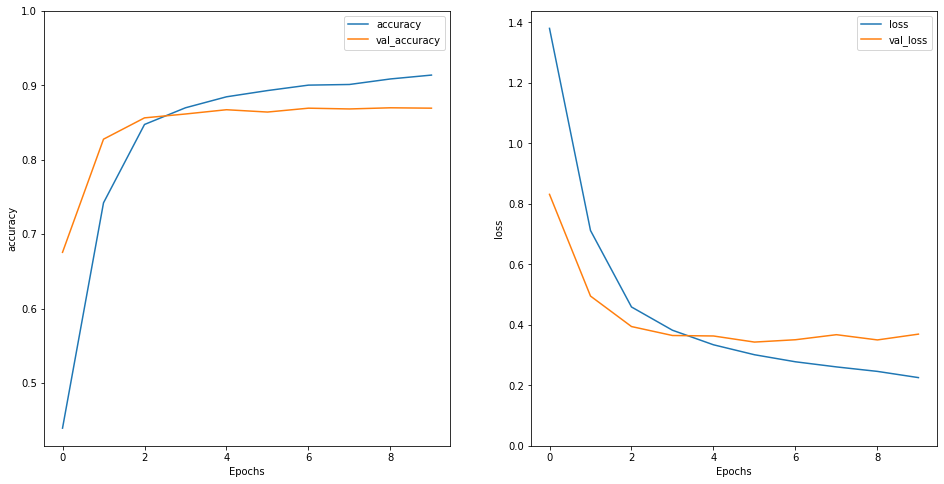

In [31]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])


plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)


### Best Model; dropout = 0.65

In [ ]:
vals = [0.1, 0.2, 0.6, 0.7, 1]

for values in vals:
  model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dropout(values),
      tf.keras.layers.Dense(6) #this is the output layer, since we have 6 emotions we should have 6 as the output number instead of 1
    ])


  model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0010000018),
               metrics=['accuracy'])

  history = model.fit(train, epochs=10,
                    validation_data=test,
                    validation_steps=30)
  

In [35]:
saved_history = []

Epoch 1/10
250/250 [==============================] - 40s 128ms/step - loss: 1.3445 - accuracy: 0.4477 - val_loss: 0.7745 - val_accuracy: 0.6979
Epoch 2/10
250/250 [==============================] - 29s 115ms/step - loss: 0.6598 - accuracy: 0.7605 - val_loss: 0.4933 - val_accuracy: 0.8281
Epoch 3/10
250/250 [==============================] - 29s 117ms/step - loss: 0.4186 - accuracy: 0.8551 - val_loss: 0.3858 - val_accuracy: 0.8547
Epoch 4/10
250/250 [==============================] - 29s 116ms/step - loss: 0.3373 - accuracy: 0.8806 - val_loss: 0.3711 - val_accuracy: 0.8646
Epoch 5/10
250/250 [==============================] - 29s 115ms/step - loss: 0.2983 - accuracy: 0.8907 - val_loss: 0.3523 - val_accuracy: 0.8672
Epoch 6/10
250/250 [==============================] - 29s 116ms/step - loss: 0.2749 - accuracy: 0.8999 - val_loss: 0.3402 - val_accuracy: 0.8729
Epoch 7/10
250/250 [==============================] - 32s 126ms/step - loss: 0.2501 - accuracy: 0.9087 - val_loss: 0.3469 - val_ac

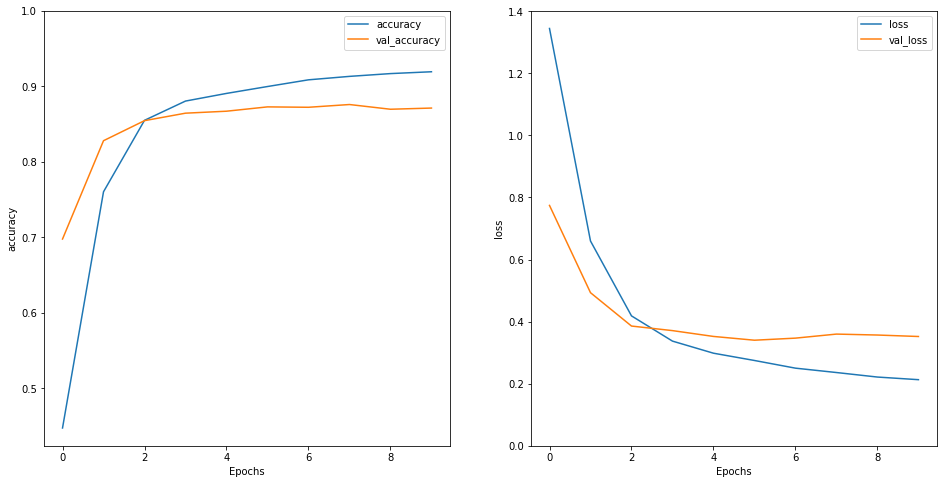

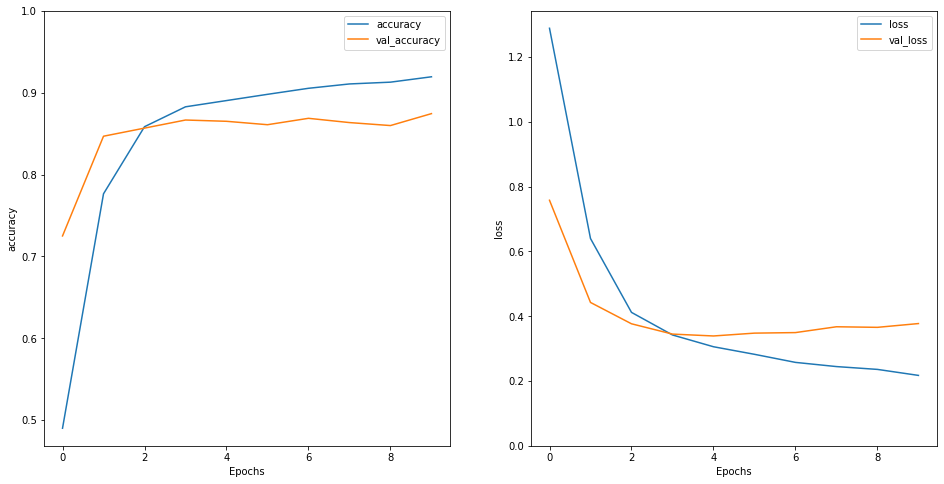

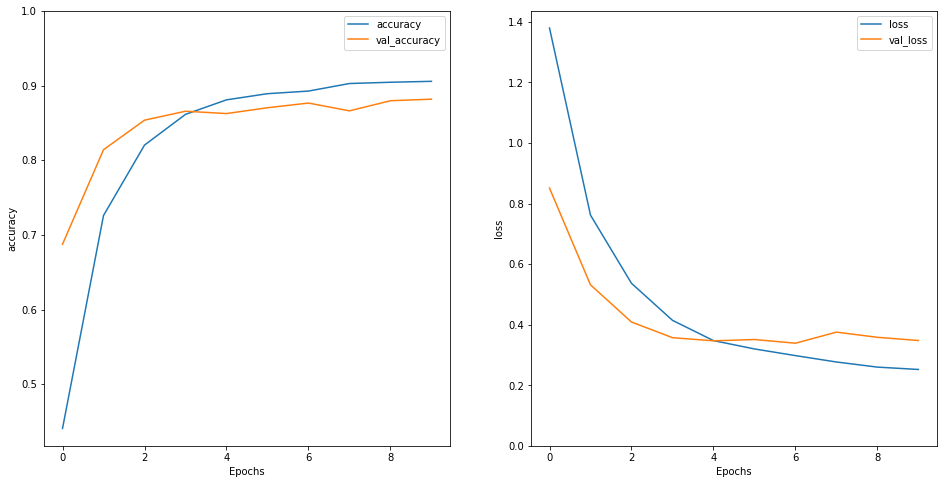

In [36]:
vals = [0.3, 0.4, 0.65]

for values in vals:
  model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dropout(values),
      tf.keras.layers.Dense(6) #this is the output layer, since we have 6 emotions we should have 6 as the output number instead of 1
    ])


  model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0010000018),
               metrics=['accuracy'])

  history = model.fit(train, epochs=10,
                    validation_data=test,
                    validation_steps=30)
  
  saved_history.append(history)

  plt.figure(figsize=(16, 8))
  plt.subplot(1, 2, 1)
  plot_graphs(history, 'accuracy')
  plt.ylim(None, 1)
  plt.subplot(1, 2, 2)
  plot_graphs(history, 'loss')
  plt.ylim(0, None)

#TODO: 
#1) learning rate for Adam (DONE)
#2)play around with layers 
> Dropout (DONE)
> Hidden Layers + number of neurons within one hidden layer
> Activation (read first)
#3) # of validation steps
#4) # of epoch
#5) optimizing the process (building a pipeline)
#6) Find a way to truly evaluate the model (over/under)
#7) Find a result set that prints out probability
